In [16]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

from google.colab import drive
drive.mount('/content/drive')

class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
cd drive/'My Drive'

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [0]:
def get_data(seed,train_bs=200, test_bs=1000):
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)
  np.random.seed(seed)

  probability_of_random = 1.0
  labels = np.array(train_dataset.targets) 
  mask = np.random.rand(len(labels)) <= probability_of_random #create mask of length labels, where entries drawn from [0,1].
  rnd_labels = np.random.choice(10, mask.sum())               #create random labels 1-10 of length of mask
  labels[mask] = rnd_labels
  labels = [int(x) for x in labels]
  train_dataset.targets = labels                              #assign new random labels to dataset
  
  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=train_bs,
                          num_workers=4,
                          shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=test_bs,
                         num_workers=4,
                         shuffle=False)
  return train_loader, test_loader

In [0]:
def compute_acc(model, data_loader):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
        probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [20]:
weights = []
weights2 = []
models = []

seeds = 10

train_loader, test_loader = get_data(0)

for i in range(seeds):
  model = torch.load('MLP_fixedrandom_iter' + str(i), map_location=lambda storage, loc: storage)
  
  models.append(model)
  weights.append(model.fc1.weight)
  weights2.append(model.fc.weight)
  #print(model.fc1.weight)
  #print(model.fc.weight)

  train_acc = compute_acc(model, train_loader)        
  print(f'train ACC: {train_acc:.2f}, seed: {i}')
        
  test_acc = compute_acc(model, test_loader)        
  print(f'Test ACC: {test_acc:.2f}')

Files already downloaded and verified
Files already downloaded and verified
train ACC: 99.28, seed: 0
Test ACC: 9.79
train ACC: 99.23, seed: 1
Test ACC: 9.99
train ACC: 99.32, seed: 2
Test ACC: 9.75
train ACC: 99.29, seed: 3
Test ACC: 9.49
train ACC: 99.23, seed: 4
Test ACC: 9.49
train ACC: 99.31, seed: 5
Test ACC: 10.07
train ACC: 99.35, seed: 6
Test ACC: 9.99
train ACC: 99.30, seed: 7
Test ACC: 9.30
train ACC: 99.28, seed: 8
Test ACC: 10.35
train ACC: 99.27, seed: 9
Test ACC: 9.81


In [0]:
#*
# @file Different utility functions
# Copyright (c) Zhewei Yao, Amir Gholami
# All rights reserved.
# This file is part of PyHessian library.
#
# PyHessian is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# PyHessian is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with PyHessian.  If not, see <http://www.gnu.org/licenses/>.
#*

import math
import numpy as np
import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt


def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7, label='Random')
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    #plt.axis([-5,20, None, None])
    plt.tight_layout()
    plt.show()

def compare_esd_plot(eigenvalues, weights, random_eigen, random_weight):
    density, grids = density_generate(eigenvalues, weights)
    random_density, random_grids = density_generate(random_eigen, random_weight)
    plt.clf()
    plt.semilogy(random_grids, random_density + 1.0e-7, label='random')
    plt.semilogy(grids, density + 1.0e-7, label='true')
    plt.legend()
    #plt.plot(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.axis([-1, 1, None, None])
    plt.tight_layout()
    plt.show()
    #plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

Files already downloaded and verified
Files already downloaded and verified
********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [35.559329986572266]

***Trace:  1754.0038029597356


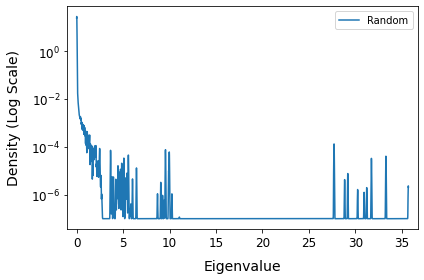

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [35.79620361328125]

***Trace:  1828.7279052734375


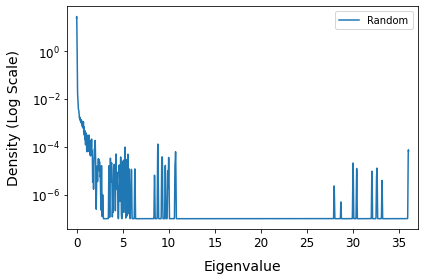

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.01814270019531]

***Trace:  1765.4931196732955


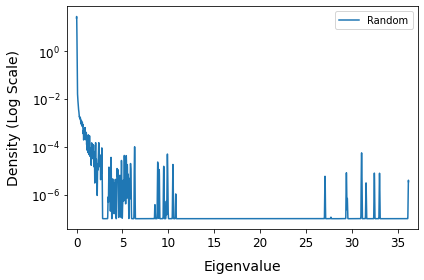

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.22938919067383]

***Trace:  1944.2567749023438


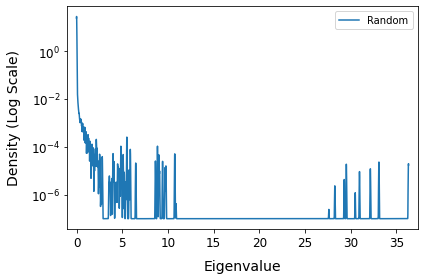

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [35.826908111572266]

***Trace:  1821.3190511067708


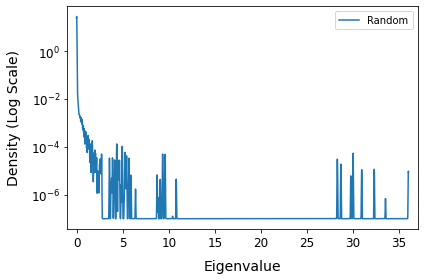

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.14094161987305]

***Trace:  1820.8287658691406


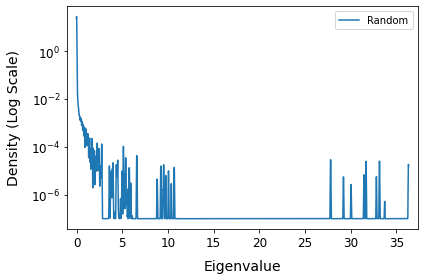

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.70748519897461]

***Trace:  1753.3102010091145


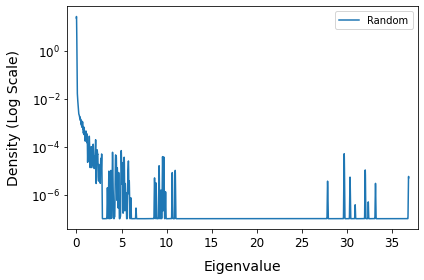

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [33.99827575683594]

***Trace:  1794.8667846679687


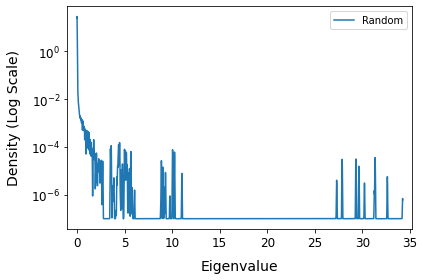

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.34085464477539]

***Trace:  1816.614071116728


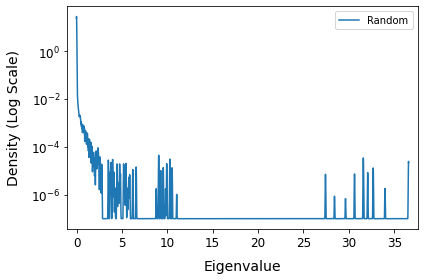

********** finish data londing and begin Hessian computation **********

***Top Eigenvalues:  [36.04982376098633]

***Trace:  1802.2085515802557


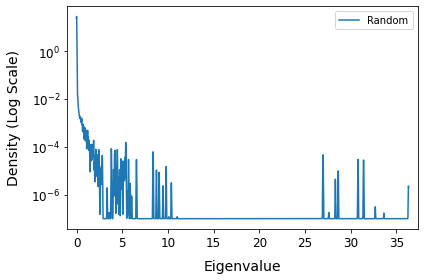

In [41]:
#*
# @file Different utility functions
# Copyright (c) Zhewei Yao, Amir Gholami
# All rights reserved.
# This file is part of PyHessian library.
#
# PyHessian is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# PyHessian is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with PyHessian.  If not, see <http://www.gnu.org/licenses/>.
#*

from __future__ import print_function

import json
import os
import sys

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from hessian import *

import math
import copy

# Settings

# set random seed to reproduce the work
torch.manual_seed(0)


# get dataset
train_loader, test_loader = get_data(0, train_bs=1000, test_bs=1)
##############
# Get the hessian data
##############
batch_num = -1.

if batch_num == 1:
    for inputs, labels in train_loader:
        hessian_dataloader = (inputs, labels)
        break
else:
    hessian_dataloader = []
    for i, (inputs, labels) in enumerate(train_loader):
        hessian_dataloader.append((inputs, labels))
        if i == batch_num - 1:
            break

# get model
class MLP(nn.Module):
  def __init__(self, n_units, init_scale=1.0):
    super(MLP, self).__init__()

    self._n_units = copy.copy(n_units)
    self._layers = []
    for i in range(1, len(n_units)):
      layer = nn.Linear(n_units[i-1], n_units[i], bias=False)
      variance = math.sqrt(2.0 / (n_units[i-1] + n_units[i]))
      layer.weight.data.normal_(0.0, init_scale * variance)
      self._layers.append(layer)

      name = 'fc%d' % i
      if i == len(n_units) - 1:
        name = 'fc'  # the prediction layer is just called fc
      self.add_module(name, layer)


  def forward(self, x):
    x = x.view(-1, self._n_units[0])
    out = self._layers[0](x)
    for layer in self._layers[1:]:
      out = F.relu(out)
      out = layer(out)
    return out

#mlp_spec = '512'
#n_units = [int(x) for x in mlp_spec.split('x')] # hidden dims
#n_units.append(10)  # output dim
#n_units.insert(0, 32*32*3)        # input dim
#model = MLP(n_units)

#if args.cuda:
#    model = model.cuda()
#model = torch.nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()  # label loss

###################
# Get model checkpoint, get saving folder
###################

trace_list = []
eigen_list = []

for mod in models:
  model = mod
  model = model.to('cuda:0')
  model.eval()
  if batch_num == 1:
    hessian_comp = hessian(model,
                           criterion,
                           data=hessian_dataloader,
                           cuda=True)
  else:
    hessian_comp = hessian(model,
                           criterion,
                           dataloader=hessian_dataloader,
                           cuda=True)

  print(
    '********** finish data londing and begin Hessian computation **********')

  top_eigenvalues, _ = hessian_comp.eigenvalues()
  trace = hessian_comp.trace()
  trace_list.append(trace)
  density_eigen, density_weight = hessian_comp.density()
  eigen_list.append((density_eigen, density_weight))

  print('\n***Top Eigenvalues: ', top_eigenvalues)
  print('\n***Trace: ', np.mean(trace))

  get_esd_plot(density_eigen, density_weight)

#np.save("randomlabel_density_eigen", density_eigen)
#np.save("randomlabel_density_weight", density_weight)

In [49]:
len(eigen_list[0][0][0])

100